In [1]:
# 필요한 package loading
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Data generation
np.random.seed(seed=0)

time = np.arange(0, 1, 1/1000)
frequency = 20
sinewave = np.sin(2 * np.pi * frequency * time) # 사인 그래프 만들기
noise = np.random.normal(0,0.3,1000) # 사인 그래프에 더할 noise 만들기

data = sinewave + noise # 데이터 형성

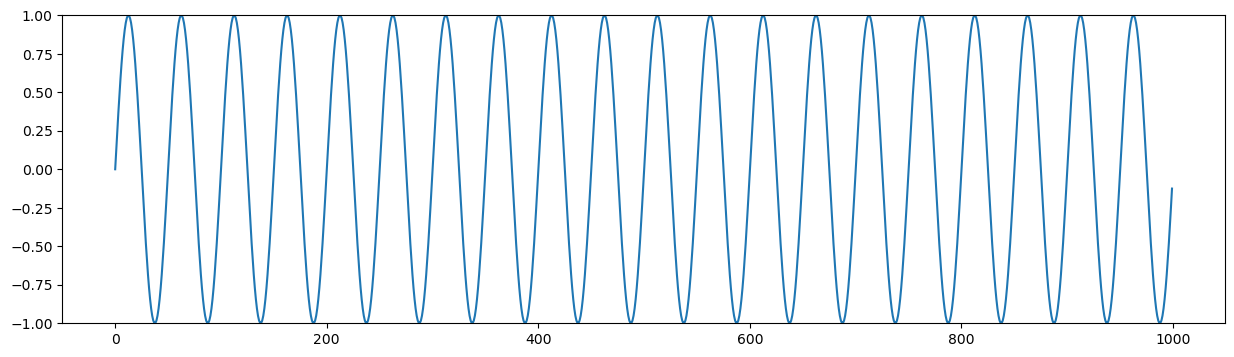

In [3]:
# Visualize the generated data (sine)
plt.figure(figsize=(15,4))
plt.plot(sinewave)
plt.ylim(-1, 1)
plt.show()

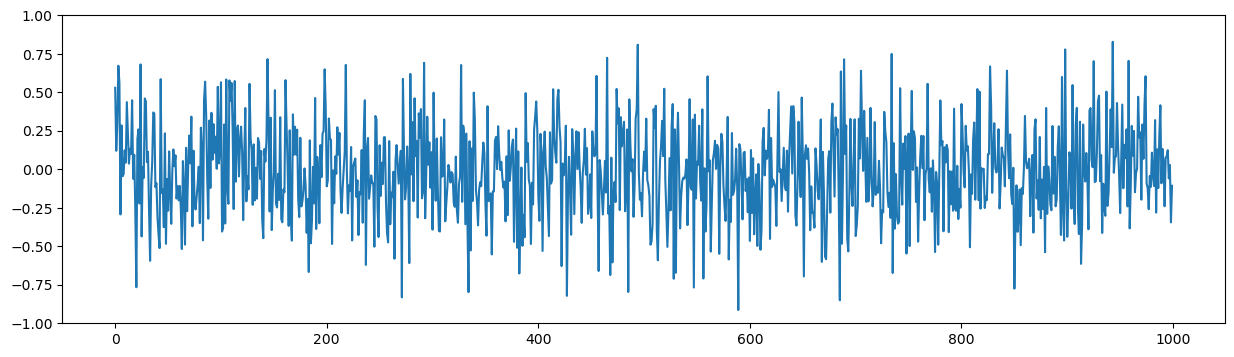

In [4]:
# Visualize the generated data (noise)
plt.figure(figsize=(15,4))
plt.plot(noise)
plt.ylim(-1, 1)
plt.show()

In [5]:
# Train and test data split

train_data = pd.DataFrame(data[0:500]) # 데이터의 반을 학습 데이터로 설정

train_data.columns = ['value']
train_data['label'] = 0

train_data.loc[160:189, 'value'] += 1.5 # 이상치 추가
train_data.loc[160:189, 'label'] = 1 # 이상치 라벨 달기

test_data = pd.DataFrame(data[500:]) # 데이터의 나머지 반을 시험 데이터로 설정

test_data.columns = ['value']
test_data['label'] = 0

test_data.loc[310:319, 'value'] += 1.5 # 이상치 추가
test_data.loc[450:459, 'value'] += 1.3
test_data.loc[310:319, 'label'] = 1 # 이상치 라벨 달기
test_data.loc[450:459, 'label'] = 1

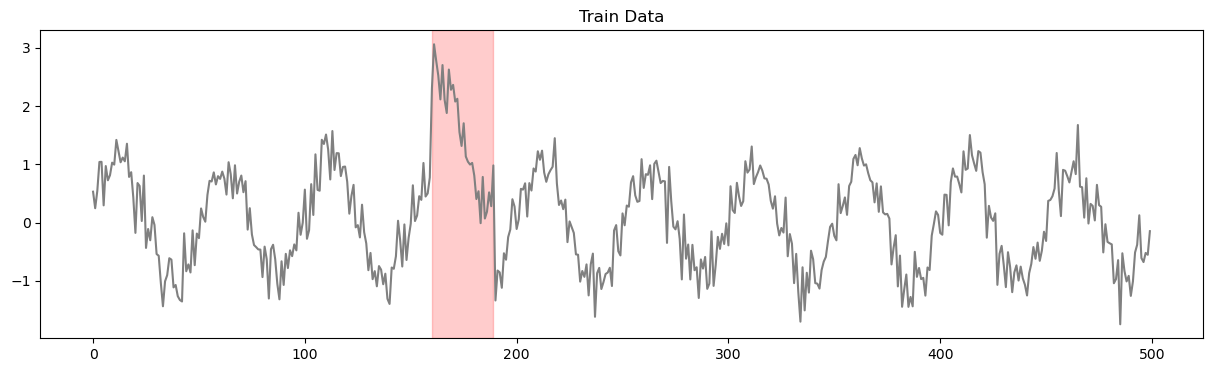

In [6]:
# visualize the train dataset
fig = plt.figure(figsize=(15,4))
fig = plt.plot(train_data['value'],color='grey')
fig = plt.axvspan(160, 189, color='red', alpha=0.2) # 이상치 부분을 빨간 배경으로 표시
fig = plt.title('Train Data')
plt.show()

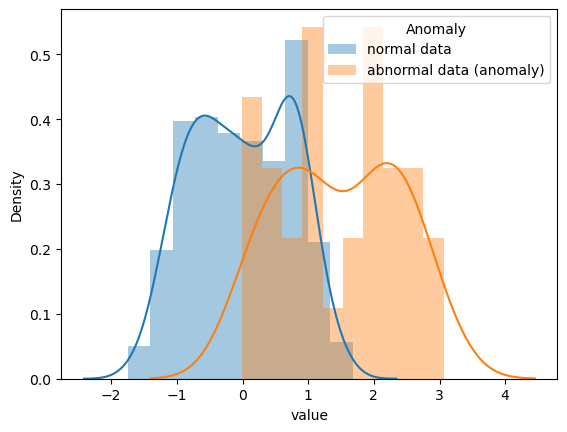

In [7]:
# visualize the distributions of normal and abnormal data
sns.distplot(train_data['value'][train_data['label']==0], bins=10, label='normal data') # 정상 데이터 표시
sns.distplot(train_data['value'][train_data['label']==1], bins=10, label='abnormal data (anomaly)') # 이상 데이터 표시
plt.legend(title="Anomaly")
plt.show()

GMM model - parameter 설명: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [8]:
# model train
# covariance types: full (each one has its own general covariance matrix), tied (all componenets share the same general covariance matrix), diag (diagnoal covariance matrix), spherical (single variance)

gm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0) # 모델 선언

means = np.array([train_data['value'][train_data['label'] == i].mean(axis=0) for i in [0,1]]) # 훈련 데이터의 각 라벨 별 평균 구하기

gm.means_init = means.reshape(2,1) # 라벨 별 평균으로 모델 초기화

gm.fit(np.array(train_data['value']).reshape(-1, 1)) # 학습 데이터로 모델 학습

GaussianMixture(means_init=array([[-0.00653296],
       [ 1.47557744]]),
                n_components=2, random_state=0)

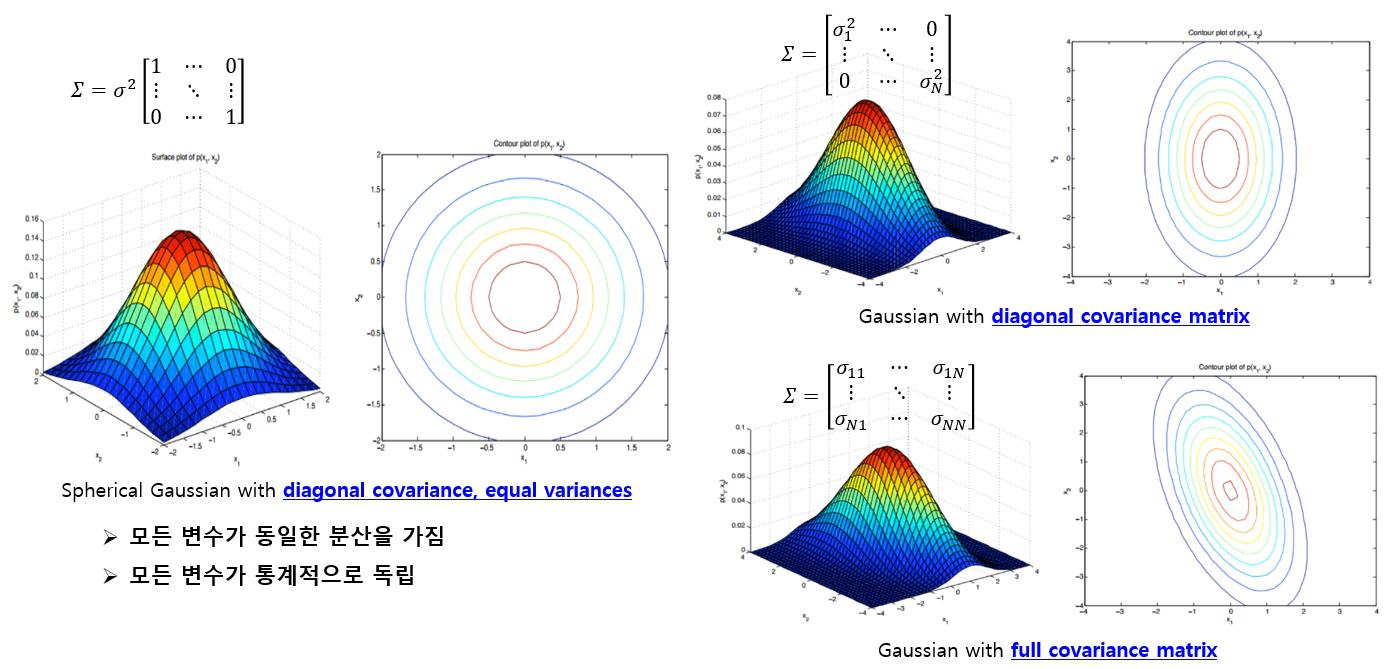

In [9]:
# Anomaly probability for test data
anomaly_proba = gm.predict_proba(np.array(test_data['value']).reshape(-1, 1))
anomaly_proba[0:20]

array([[0.80343536, 0.19656464],
       [0.80333285, 0.19666715],
       [0.54731967, 0.45268033],
       [0.71487852, 0.28512148],
       [0.67025655, 0.32974345],
       [0.64916453, 0.35083547],
       [0.76734175, 0.23265825],
       [0.71362449, 0.28637551],
       [0.60215357, 0.39784643],
       [0.17017264, 0.82982736],
       [0.1971786 , 0.8028214 ],
       [0.13950152, 0.86049848],
       [0.53408208, 0.46591792],
       [0.65270857, 0.34729143],
       [0.41692482, 0.58307518],
       [0.29303869, 0.70696131],
       [0.26804265, 0.73195735],
       [0.22138852, 0.77861148],
       [0.37413974, 0.62586026],
       [0.20188286, 0.79811714]])

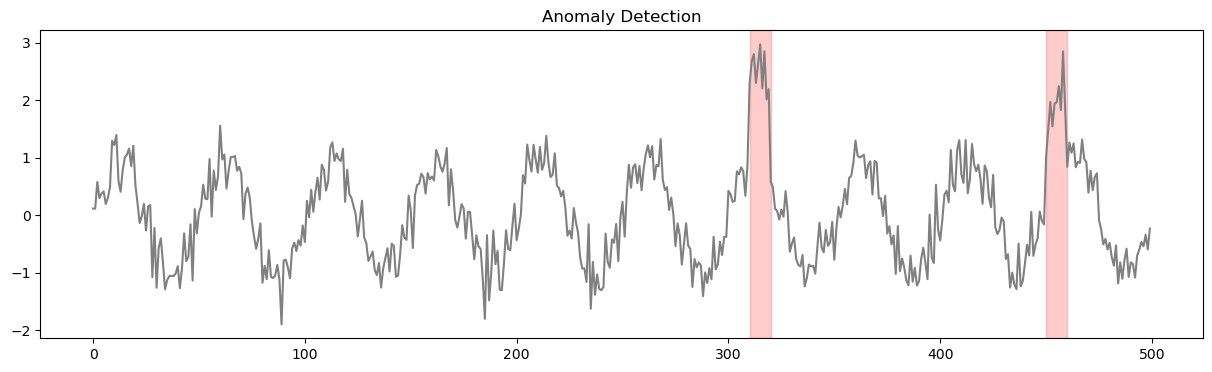

In [10]:
# visualize the test data
fig = plt.figure(figsize=(15,4))
fig = plt.plot(test_data['value'],color='grey')
fig = plt.title('Anomaly Detection')
fig = plt.axvspan(310, 320, color='red', alpha=0.2) # 이상치 영역: 빨간색
fig = plt.axvspan(450, 460, color='red', alpha=0.2)
plt.show()

In [11]:
results = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1-score'])  # 결과 저장용 DataFrame

for i in np.arange(0.1, 1, 0.1):  # threshold 0.1부터 0.9까지
    anomaly_predict = (anomaly_proba[:, 1] > i)
    scores = classification_report(test_data['label'], anomaly_predict, target_names=['normal', 'anomaly'], output_dict=True)
    
    result = {
        'threshold': np.round(i, 1),
        'precision': scores['macro avg']['precision'],
        'recall': scores['macro avg']['recall'],
        'f1-score': scores['macro avg']['f1-score']
    }
    
    results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)  # append 대신 concat 사용

results = results.set_index('threshold')
results

,precision,recall,f1-score
threshold,,,
0.1,0.536101,0.732292,0.384552
0.2,0.544053,0.784375,0.443521
0.3,0.552083,0.820833,0.485203
0.4,0.564935,0.860417,0.533829
0.5,0.576336,0.884375,0.567079
0.6,0.600000,0.916667,0.621212
0.7,0.658730,0.955208,0.717518
0.8,0.762811,0.957292,0.829752
0.9,0.996894,0.925000,0.957902


In [12]:
pd.DataFrame(scores) # one case

,normal,anomaly,accuracy,macro avg,weighted avg
precision,0.993789,1.000000,0.994,0.996894,0.994037
recall,1.000000,0.850000,0.994,0.925000,0.994000
f1-score,0.996885,0.918919,0.994,0.957902,0.993766
support,480.000000,20.000000,0.994,500.000000,500.000000


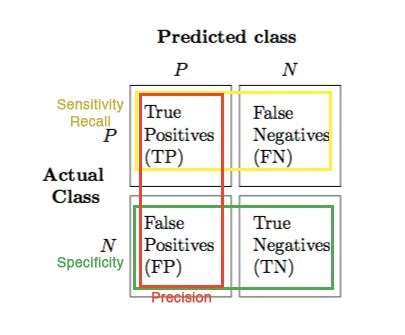

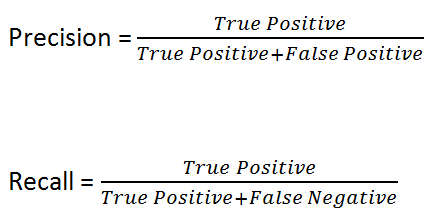

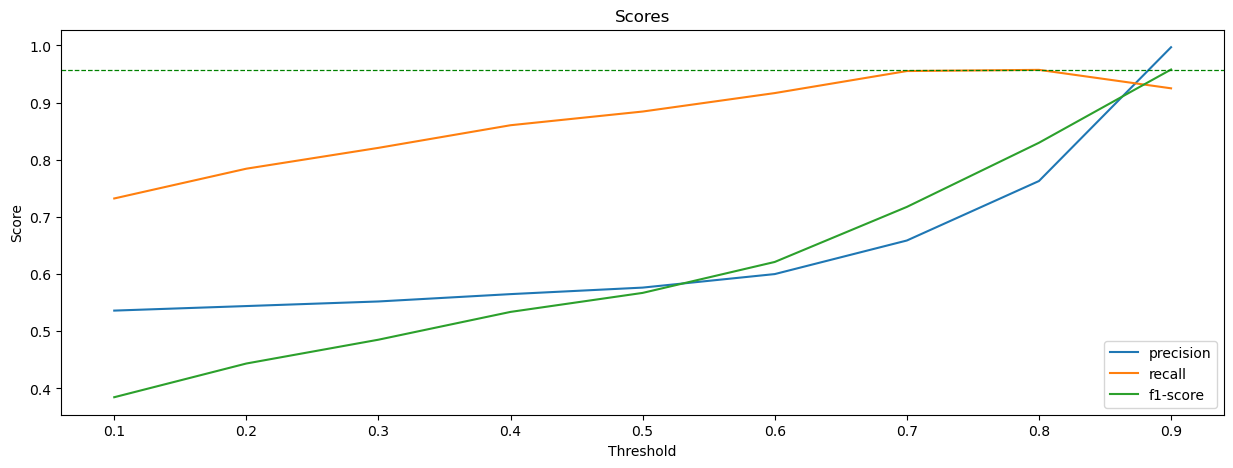

In [13]:
# visualize the metrics according to the threshold
plt.figure(figsize = (15, 5))
plt.plot(results['precision'], label='precision')
plt.plot(results['recall'], label='recall')
plt.plot(results['f1-score'], label='f1-score')
plt.axhline(float(results['f1-score'].max()), lw=0.9, ls='--', color='green') # f1-score가 가장 높은 경우를 점선으로 표시
plt.title('Scores')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [14]:
# indexing the anomalies

print(float(results['f1-score'].idxmax())) # threshold가 0.8일 때 f1-score 최대치를 가짐

anomaly_index = (anomaly_proba[:,1] > float(results['f1-score'].idxmax())).nonzero()
anomaly_index

0.9


(array([310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 452, 454, 455,
        456, 457, 458, 459]),)

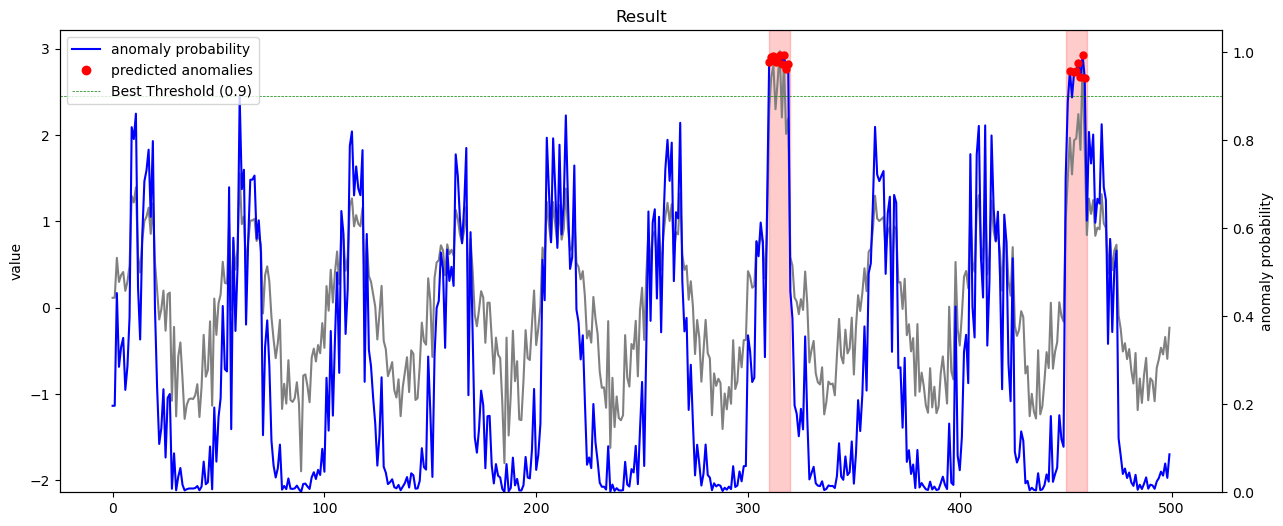

In [15]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# 원래 시계열 시각화
ax1.plot(test_data['value'], color='grey')
ax1.set_ylabel('value')
ax1.set_title('Result')
ax1.axvspan(310, 320, color='red', alpha=0.2)
ax1.axvspan(450, 460, color='red', alpha=0.2)

# 이상 확률 시각화
ax2 = ax1.twinx()

# anomaly probability line
line1, = ax2.plot(anomaly_proba[:, 1], label='anomaly probability', color='blue')

# predicted anomalies (points)
ax2.plot(anomaly_index, anomaly_proba[anomaly_index, 1],
         ls="", marker="o", color='red', markersize=5)
# 범례용 proxy
scatter_proxy = plt.Line2D([0], [0], ls="", marker="o", color='red', label='predicted anomalies')

# threshold 수평선
threshold = float(results['f1-score'].idxmax())
line3 = ax2.axhline(y=threshold, ls='--', lw=0.5, color='green', label=f'Best Threshold ({threshold})')

# 범례: 왼쪽 위로!
ax2.legend(handles=[line1, scatter_proxy, line3], loc='upper left')

# 축 설정
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('anomaly probability')

plt.show()
